The idea of this notebook is to calculate scoring parameters for the RibosomalFrameshift sensor of EuGene using transcript sequences.
The transcripts are scanned for long (unshifted) ORFs. The distance to the next stop codon on the +1 and the +2 strand subsequent to the ORF is determined. Depending on these distances the stop at the end of the ORF is characterized as terminating, +1 shifting or +2 shifting.
The +1 frameshift score for a codon preceding a stop is calculated as:

log(frequency_+1_shifting/(frequency_terminating + frequency_+1_shifting + frequency_+2_shifting))

Similarly the +2 frameshift score and terminating score is computed.

The hyperparameters for classifying the stops were estimated from the plots below.

In [1]:
from Bio import SeqIO
import re
from matplotlib import pyplot as plt
import numpy as np

In [2]:
transcripts_list = list(SeqIO.parse("transcripts_v3_forward.fasta", "fasta"))

In [3]:
#f'RibosomalFrameShift.type[{c}]    {typ} \n
#RibosomalFrameShift.pat[{c}] {motif} \n
#RibosomalFrameShift.newStatePos[{c}] 4 \n
#RibosomalFrameShift.patP*[{c}] {score} \n
#RibosomalFrameShift.patPNo*[{c}] {score_no} \n
#RibosomalFrameShift.requiredEstSupport[{c}] 0 \n'

In [4]:
alphabet = ['A', 'C', 'G', 'T']
dictionary = {}
plot_dict = {}
for l in alphabet:
    for j in alphabet:
        for k in alphabet:
            if not (l+j+k == 'TAA' or l+j+k == 'TAG'):
                dictionary[(l+j+k, '+1')] = 0
                dictionary[(l+j+k, '+2')] = 0
                dictionary[(l+j+k, 'term')] = 1
                plot_dict[(l+j+k)] = []
x = 300
# regular expression that finds each occurence of a stop codons downstream of a ORF of length 3*x
pattern = f"(?:[ACG][ACGT]{{{2}}}|[T][CGT][ACGT]|TAC|TAT){{{x}}}(?:TA[AG])"

for transcript in transcripts_list:
    for match in re.finditer(pattern, str(transcript.seq)):
        seq = str(transcript.seq)
    
        ending_seq = seq[match.span()[1]-2:]
        counter = 0
        while ending_seq[counter:counter+3] != 'TAA' and ending_seq[counter:counter+3] != 'TAG' and counter < len(ending_seq)-3:
            counter += 3
        if counter >= len(ending_seq)-3:
            dist_to_1_stop = 0
        else:        
            dist_to_1_stop = counter
        
        
        ending_seq = seq[match.span()[1]-1:]
        counter = 0
        while ending_seq[counter:counter+3] != 'TAA' and ending_seq[counter:counter+3] != 'TAG' and counter < len(ending_seq)-3:
            counter += 3
        if counter >= len(ending_seq)-3:
            dist_to_2_stop = 0
        else:
            dist_to_2_stop = counter
        
        roi = seq[match.span()[1]-6:match.span()[1]-3]
        if dist_to_1_stop < 300 and dist_to_2_stop < 300:
            dictionary[(roi,'term')] += 1
        elif dist_to_1_stop > 300 and dist_to_2_stop < 250:
            dictionary[(roi,'+1')] += 1
        elif dist_to_2_stop > 300 and dist_to_1_stop < 250:
            dictionary[(roi,'+2')] += 1
   
        plot_dict[roi].append((dist_to_1_stop, dist_to_2_stop))


c = 0
res = ''
for l in alphabet:
    for j in alphabet:
        for k in alphabet:  
            if not (l+j+k == 'TAA' or l+j+k == 'TAG'):
                motif = l+j+k
                su = dictionary[(motif), 'term'] + dictionary[(motif, '+2')] + dictionary[(motif, '+1')]
                score_term = np.log2(dictionary[(motif,'term')]/su)
                if dictionary[motif,'+1']:
                    score_1 = np.log2(dictionary[motif,'+1']/su)
                    res += f'RibosomalFrameShift.type[{c}]    insertion1 \nRibosomalFrameShift.pat[{c}] {motif}TAA \nRibosomalFrameShift.newStatePos[{c}] 4 \nRibosomalFrameShift.patP*[{c}] {score_1} \nRibosomalFrameShift.patPNo*[{c}] {score_term} \nRibosomalFrameShift.requiredEstSupport[{c}] 0 \n#\n'
                    c+=1
                    res += f'RibosomalFrameShift.type[{c}]    insertion1 \nRibosomalFrameShift.pat[{c}] {motif}TAG \nRibosomalFrameShift.newStatePos[{c}] 4 \nRibosomalFrameShift.patP*[{c}] {score_1} \nRibosomalFrameShift.patPNo*[{c}] {score_term} \nRibosomalFrameShift.requiredEstSupport[{c}] 0 \n#\n'
                    c+=1
                if dictionary[motif,'+2']:
                    score_2 = np.log2(dictionary[motif,'+2']/su)
                    res += f'RibosomalFrameShift.type[{c}]    deletion1 \nRibosomalFrameShift.pat[{c}] {motif}TAA \nRibosomalFrameShift.newStatePos[{c}] 4 \nRibosomalFrameShift.patP*[{c}] {score_2} \nRibosomalFrameShift.patPNo*[{c}] {score_term} \nRibosomalFrameShift.requiredEstSupport[{c}] 0 \n#\n'
                    c+=1
                    res += f'RibosomalFrameShift.type[{c}]    deletion1 \nRibosomalFrameShift.pat[{c}] {motif}TAG \nRibosomalFrameShift.newStatePos[{c}] 4 \nRibosomalFrameShift.patP*[{c}] {score_2} \nRibosomalFrameShift.patPNo*[{c}] {score_term} \nRibosomalFrameShift.requiredEstSupport[{c}] 0 \n#\n'
                    c+=1
                    
                    
print(res)

RibosomalFrameShift.type[0]    insertion1 
RibosomalFrameShift.pat[0] AAATAA 
RibosomalFrameShift.newStatePos[0] 4 
RibosomalFrameShift.patP*[0] -1.0097413944782 
RibosomalFrameShift.patPNo*[0] -1.0534026232743399 
RibosomalFrameShift.requiredEstSupport[0] 0 
#
RibosomalFrameShift.type[1]    insertion1 
RibosomalFrameShift.pat[1] AAATAG 
RibosomalFrameShift.newStatePos[1] 4 
RibosomalFrameShift.patP*[1] -1.0097413944782 
RibosomalFrameShift.patPNo*[1] -1.0534026232743399 
RibosomalFrameShift.requiredEstSupport[1] 0 
#
RibosomalFrameShift.type[2]    deletion1 
RibosomalFrameShift.pat[2] AAATAA 
RibosomalFrameShift.newStatePos[2] 4 
RibosomalFrameShift.patP*[2] -5.537218400538596 
RibosomalFrameShift.patPNo*[2] -1.0534026232743399 
RibosomalFrameShift.requiredEstSupport[2] 0 
#
RibosomalFrameShift.type[3]    deletion1 
RibosomalFrameShift.pat[3] AAATAG 
RibosomalFrameShift.newStatePos[3] 4 
RibosomalFrameShift.patP*[3] -5.537218400538596 
RibosomalFrameShift.patPNo*[3] -1.053402623274339

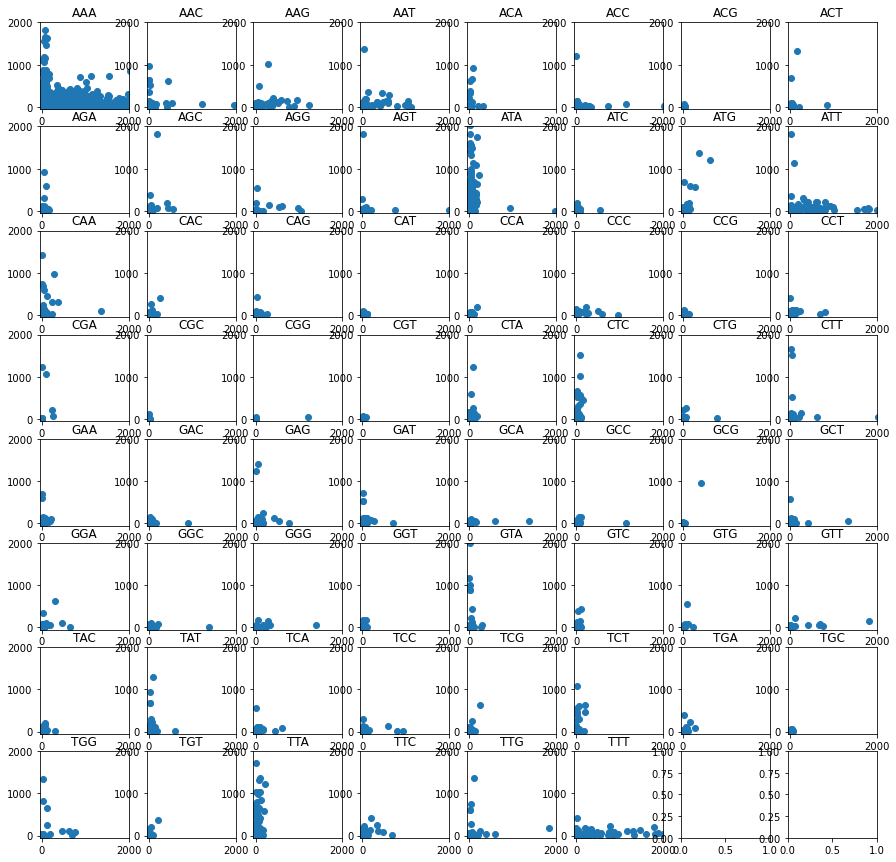

In [5]:
# plots for each codon preceding a stop
# each datapoint corresponds to an ORF
# on the x axis is the distance to the next stop on the +1 frame on the y axis on the +2 frame
# the plots clearly show (for some codons) that they have a propensity to shift and the type of the shift
fig, axs = plt.subplots(8,8,figsize=(15,15))
codons = plot_dict.keys()
for ax,codon in zip(axs.flatten(), codons):
    ax.scatter([x[0] for x in plot_dict[codon]], [x[1] for x in plot_dict[codon]])
    ax.set_title(codon)
    ax.set_xlim((-50,2000))
    ax.set_ylim((-50,2000))